In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import splitfolders

In [ ]:
input_folder = "Dataset_FIX"
resized_folder = "dataset_resize"
split_folder = "dataset_split"
augmented_folder = "dataset_augmented"

### 1. Resize Gambar

In [ ]:
def resize_images(input_dir, output_dir, img_size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)

    class_names = os.listdir(input_dir)
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        first_img_path = None

        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                
                img_resized = img.resize(img_size)
                
                img_output_path = os.path.join(output_class_path, img_name)
                img_resized.save(img_output_path)

                # Simpan satu gambar untuk visualisasi
                if first_img_path is None:
                    first_img_path = img_path
                    visualize_resize(img, img_resized, class_name)

    print("Resize gambar selesai.")

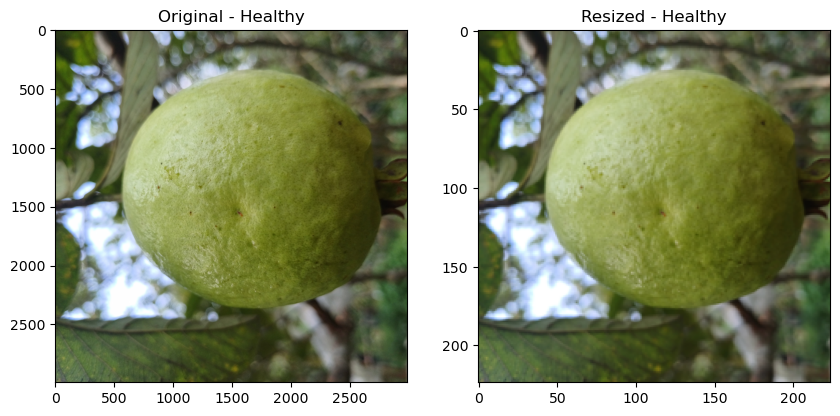

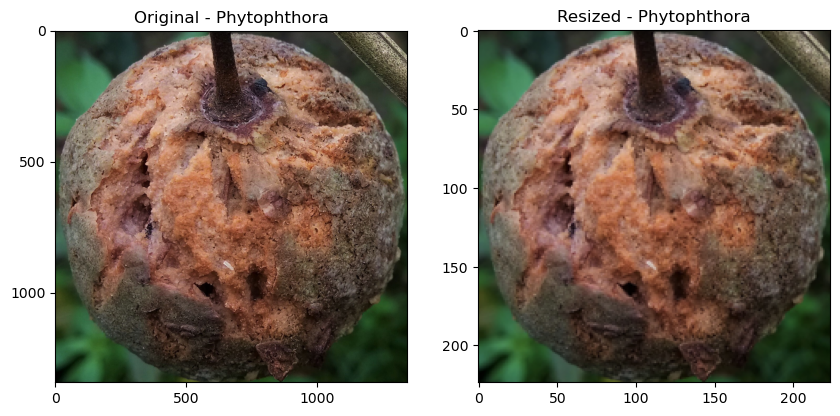

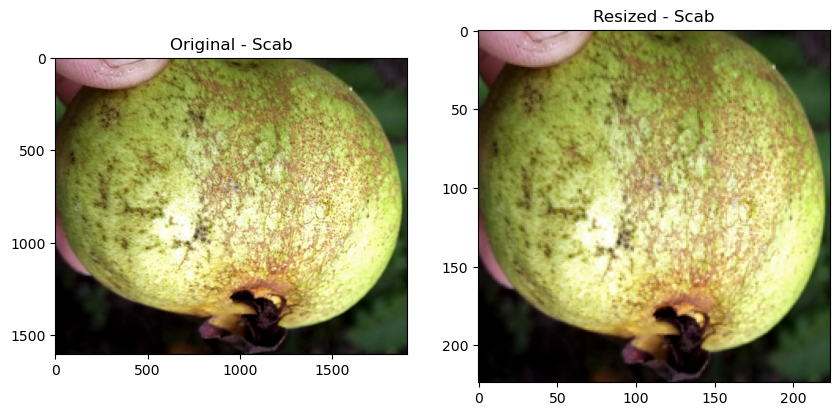

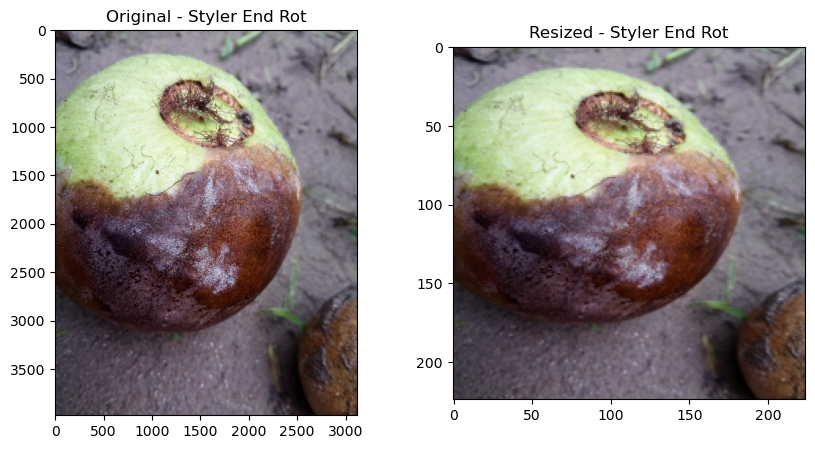

Resize gambar selesai.


In [9]:
# Visualisasi sebelum dan sesudah resize
def visualize_resize(original_img, resized_img, class_name):
    plt.figure(figsize=(10, 5))

    # Gambar sebelum resize
    plt.subplot(1, 2, 1)
    plt.title(f"Original - {class_name}")
    plt.imshow(original_img)
    plt.xticks(np.arange(0, original_img.width, step=500))
    plt.yticks(np.arange(0, original_img.height, step=500))

    # Gambar setelah resize
    plt.subplot(1, 2, 2)
    plt.title(f"Resized - {class_name}")
    plt.imshow(resized_img)
    plt.xticks(np.arange(0, resized_img.width, step=50))
    plt.yticks(np.arange(0, resized_img.height, step=50))

    plt.show()

resize_images(input_folder, resized_folder)


### 2. Pembagian Data

In [3]:
# 2. Split Dataset
splitfolders.ratio(
    resized_folder, 
    output=split_folder, 
    seed=42, 
    ratio=(0.8, 0.1, 0.1),
    move=False  
)

print("Pembagian dataset selesai.")

Pembagian dataset selesai.


In [51]:
def count_images(folder_path):
    total_images = 0

    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(folder_path, subset)
        subset_total = 0 
        
        print(f"Subset: {subset}")

        for class_name in os.listdir(subset_path):
            class_path = os.path.join(subset_path, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                subset_total += num_images
                print(f"  - {class_name}: {num_images} gambar")
        
        print(f"  Total gambar di {subset}: {subset_total} gambar\n")
        total_images += subset_total

    print(f"Total seluruh gambar: {total_images} gambar\n")

count_images(split_folder)

Subset: train
  - Healthy: 84 gambar
  - Phytophthora: 81 gambar
  - Scab: 81 gambar
  - Styler End Rot: 76 gambar
  Total gambar di train: 322 gambar

Subset: val
  - Healthy: 10 gambar
  - Phytophthora: 10 gambar
  - Scab: 10 gambar
  - Styler End Rot: 9 gambar
  Total gambar di val: 39 gambar

Subset: test
  - Healthy: 11 gambar
  - Phytophthora: 11 gambar
  - Scab: 11 gambar
  - Styler End Rot: 10 gambar
  Total gambar di test: 43 gambar

Total seluruh gambar: 404 gambar



### 3. Data Augmentation

In [3]:
def rotate_image(img, angle):
    return img.rotate(angle)

def shift_image(img, tx, ty):
    return img.transform(img.size, Image.AFFINE, (1, 0, tx, 0, 1, ty))

def zoom_image(img, zoom):
    w, h = img.size
    w_taken = int(zoom * w)
    h_taken = int(zoom * h)

    w_start = (w - w_taken) // 2
    h_start = (h - h_taken) // 2

    img_cropped = img.crop((w_start, h_start, w_start + w_taken, h_start + h_taken))
    img_resized = img_cropped.resize((w, h), Image.Resampling.BICUBIC)
    
    return img_resized

def flip_image(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)


def augmentation(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        first_img_path = None

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(img_path)

                img_name = os.path.splitext(img_name)[0]

                # Augmentasi
                augmented_images = [
                    rotate_image(img, angle) for angle in range(-30, 31, 10) if angle != 0
                ] + [
                    shift_image(img, tx, ty) for tx, ty in [(-20, -20), (20, 20)]
                ] + [
                    zoom_image(img, z) for z in [0.8, 0.6]
                ] + [
                    flip_image(img)
                ]

                # Simpan semua gambar hasil augmentasi
                for i, aug_img in enumerate(augmented_images):
                    aug_img.save(os.path.join(output_class_path, f"{img_name}_aug_{i}.jpg"))

                if first_img_path is None:
                    first_img_path = img_path
                    visualize_augmentation(img, augmented_images, class_name)

    print("Augmentasi selesai.")


In [4]:
def visualize_augmentation(original_img, augmented_images, class_name):
    plt.figure(figsize=(8, 18))

    plt.subplot(6, 2, 1)
    plt.title(f"Original - {class_name}")
    plt.imshow(original_img)
    plt.xticks(np.arange(0, original_img.size[0], step=50))
    plt.yticks(np.arange(0, original_img.size[1], step=50))

    augmentation_labels = [
        "Rotate -30°", "Rotate -20°", "Rotate -10°",
        "Rotate 10°", "Rotate 20°", "Rotate 30°",
        "Shift (-20, -20)", "Shift (20, 20)",
        "Zoom (0.8x)", "Zoom (0.6x)",
        "Horizontal Flip"
    ]

    for i, (aug_img, label) in enumerate(zip(augmented_images, augmentation_labels)):
        plt.subplot(6, 2, i + 2)
        plt.imshow(aug_img)
        plt.title(label)
        plt.xticks(np.arange(0, aug_img.size[0], step=50))
        plt.yticks(np.arange(0, aug_img.size[1], step=50))

    plt.tight_layout(pad=2.0)
    plt.show()

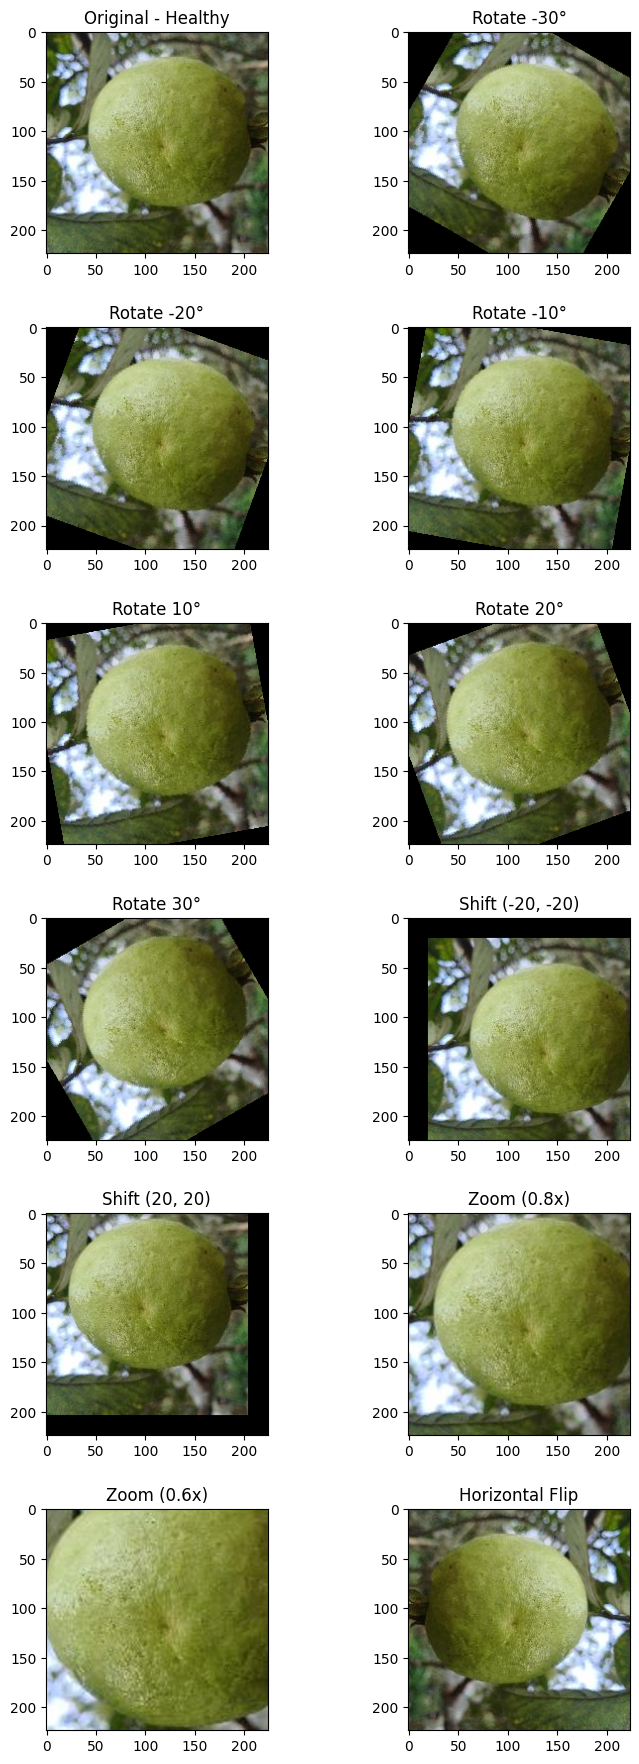

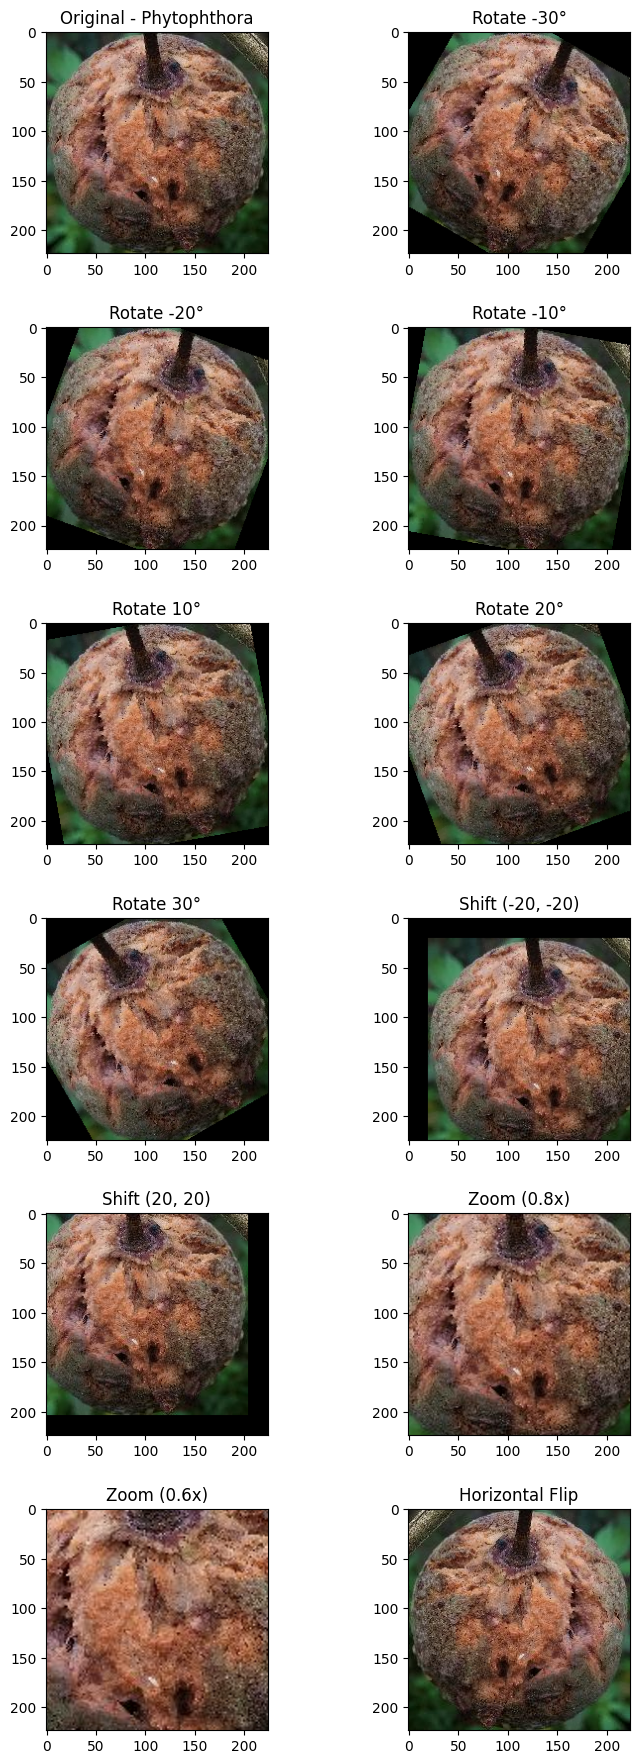

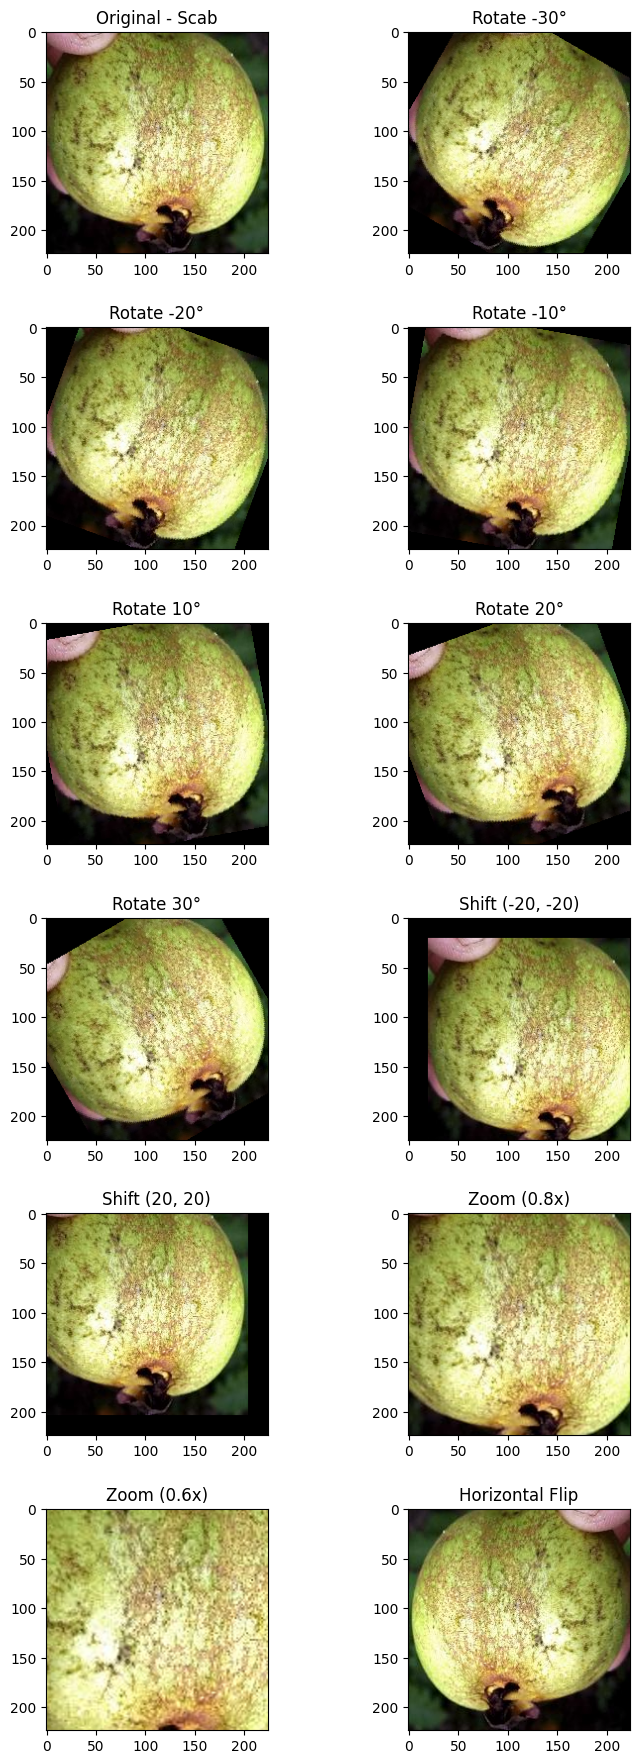

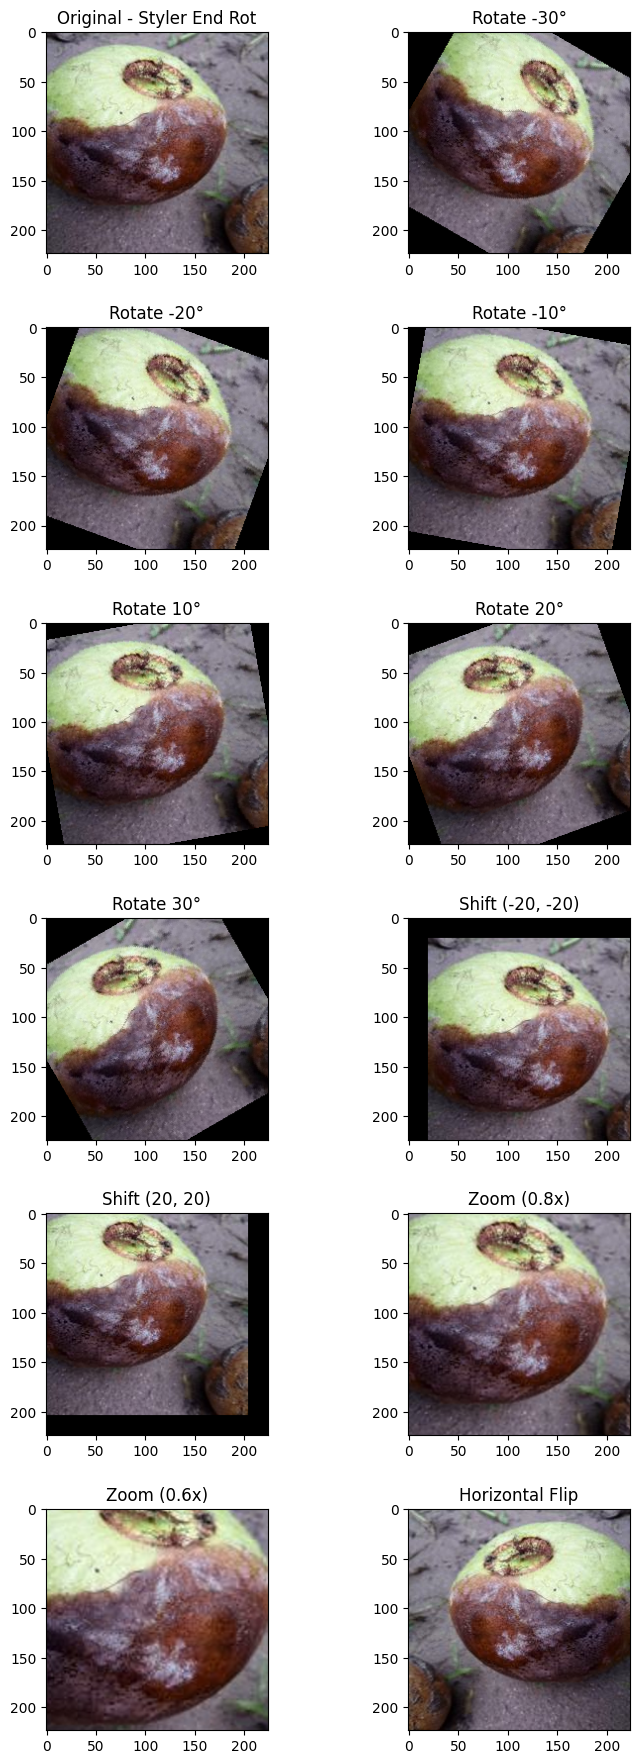

Augmentasi selesai.


In [5]:
augmentation(split_folder + '/train', augmented_folder)

In [55]:
def count_aug(folder_path):
    print("Jumlah Gambar Hasil Augmentasi:")
    total_images = 0

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            total_images += num_images
            print(f"  - {class_name}: {num_images} gambar")        

    print(f"Total seluruh gambar: {total_images} gambar\n")

count_aug(augmented_folder)


Jumlah Gambar Hasil Augmentasi:
  - Healthy: 924 gambar
  - Phytophthora: 891 gambar
  - Scab: 891 gambar
  - Styler End Rot: 836 gambar
Total seluruh gambar: 3542 gambar

